##### Imports & Constants

In [8]:
import pathlib
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn.ensemble as ske
import sklearn.metrics as skm

FINAL_DATA_PATH = pathlib.Path('..') / 'data' / 'final' / 'final_data.csv'
PCA_DATA_PATH = pathlib.Path('..') / 'data' / 'final' / 'pca_data.csv'

final_data = pd.read_csv(FINAL_DATA_PATH)
pca_data = pd.read_csv(PCA_DATA_PATH)

X, y = final_data.drop('position', axis=1), final_data['position']
pca_X, pca_y = pca_data, final_data['position']

# Split data into train and test sets
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
pca_X_train, pca_X_test, pca_y_train, pca_y_test = ms.train_test_split(pca_X, pca_y, test_size=0.2, random_state=42, shuffle=True)

# Split train data into train and validation sets
X_train, X_val, y_train, y_val = ms.train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

X_train_features_count = X_train.shape[1]
pca_X_train_features_count = pca_X_train.shape[1]

##### Inital Model

In [2]:
rf = ske.RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

""" 
0 -> ST
1 -> LW
2 -> RW
3 -> CM
4 -> RB
5 -> LB
6 -> CB
"""

# Metrics
print(skm.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      4850
           1       0.55      0.51      0.53      2460
           2       0.61      0.47      0.53      2541
           3       0.80      0.86      0.83      8355
           4       0.80      0.75      0.77      2513
           5       0.86      0.82      0.84      2495
           6       0.92      0.91      0.91      5509

    accuracy                           0.81     28723
   macro avg       0.77      0.75      0.76     28723
weighted avg       0.80      0.81      0.80     28723



<AxesSubplot: >

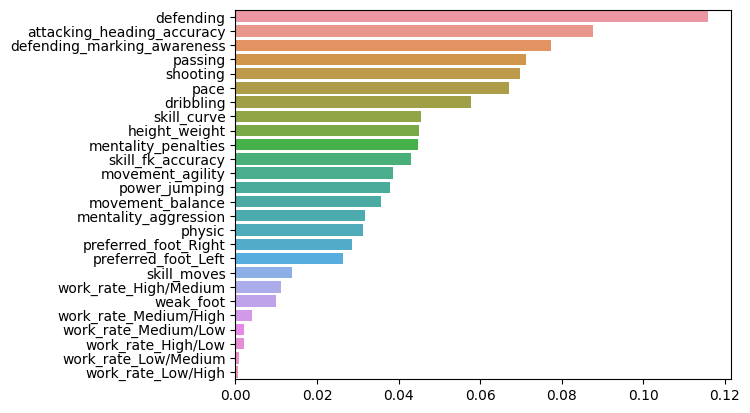

In [3]:
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)

##### Inital Model (PCA)

In [5]:
rf = ske.RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(pca_X_train, pca_y_train)
y_pred = rf.predict(pca_X_test)

""" 
0 -> ST
1 -> LW
2 -> RW
3 -> CM
4 -> RB
5 -> LB
6 -> CB
"""

# Metrics
print(skm.classification_report(pca_y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4850
           1       0.51      0.47      0.49      2460
           2       0.52      0.41      0.46      2541
           3       0.77      0.84      0.81      8355
           4       0.76      0.72      0.74      2513
           5       0.84      0.80      0.82      2495
           6       0.90      0.89      0.90      5509

    accuracy                           0.78     28723
   macro avg       0.74      0.72      0.73     28723
weighted avg       0.77      0.78      0.77     28723



<AxesSubplot: >

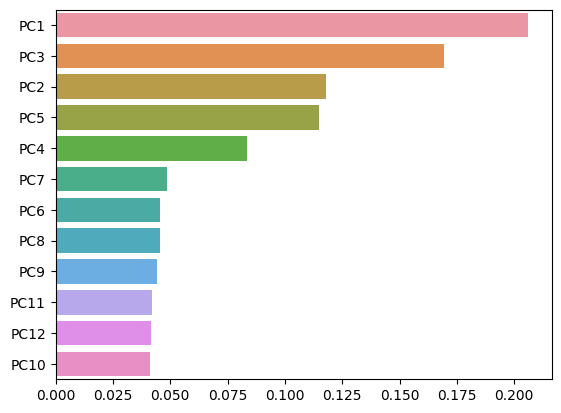

In [6]:
feature_importance = pd.Series(rf.feature_importances_, index=pca_X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance, y=feature_importance.index)

In [7]:
lr = lm.LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Metrics
print(skm.classification_report(pca_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.87      4850
           1       0.45      0.26      0.32      2460
           2       0.44      0.36      0.40      2541
           3       0.74      0.85      0.79      8355
           4       0.74      0.70      0.72      2513
           5       0.83      0.80      0.81      2495
           6       0.88      0.90      0.89      5509

    accuracy                           0.76     28723
   macro avg       0.70      0.68      0.69     28723
weighted avg       0.74      0.76      0.75     28723



## Tensorflow softmax ANN

In [4]:
""" 
This model was tested with different number of layers and neurons per layer.
The best result was achieved with the following configuration:
    - 5 layers
    - 256 neurons in the first layer
    - 128 neurons in the second layer
    - 64 neurons in the third layer
    - 32 neurons in the fourth layer
    - 7 neurons in the fifth layer

The model was trained with 100 epochs and a batch size of 32.
"""


import tensorflow as tf

# read model

model = None
try:
    model = tf.keras.models.load_model('model.h5')
except:
    pass

if not model:
    
    input_size = X_train_features_count

    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_size, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    # compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # train model
    model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val)
    )
    

# evaluate model
model.evaluate(X_test, y_test, verbose=2)

Epoch 1/100
2873/2873 [==============================] - 3s 1ms/step - loss: 0.7424 - accuracy: 0.7143 - val_loss: 0.6577 - val_accuracy: 0.7496
Epoch 2/100
2873/2873 [==============================] - 3s 970us/step - loss: 0.6633 - accuracy: 0.7462 - val_loss: 0.6482 - val_accuracy: 0.7511
Epoch 3/100
2873/2873 [==============================] - 3s 975us/step - loss: 0.6500 - accuracy: 0.7503 - val_loss: 0.6611 - val_accuracy: 0.7469
Epoch 4/100
2873/2873 [==============================] - 3s 971us/step - loss: 0.6417 - accuracy: 0.7527 - val_loss: 0.6257 - val_accuracy: 0.7619
Epoch 5/100
2873/2873 [==============================] - 3s 953us/step - loss: 0.6338 - accuracy: 0.7572 - val_loss: 0.6188 - val_accuracy: 0.7660
Epoch 6/100
2873/2873 [==============================] - 3s 954us/step - loss: 0.6282 - accuracy: 0.7614 - val_loss: 0.6313 - val_accuracy: 0.7636
Epoch 7/100
2873/2873 [==============================] - 3s 983us/step - loss: 0.6240 - accuracy: 0.7611 - val_loss: 0.6

[0.7757745981216431, 0.7640914916992188]

In [10]:
# descirbe model
model.summary()

# save model
model.save('model.h5')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 26)                702       
                                                                 
 dense_1 (Dense)             (None, 256)               6912      
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 7)                 231       
                                                                 
Total params: 51,077
Trainable params: 51,077
Non-traina

In [16]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

try:
    model = pickle.load(open('randomforest_model.sav', 'rb'))
except:
    model = None
    
if not model:
    
    param_grid = {
        'n_estimators': [25, 50, 100, 150],
        'max_features': ['sqrt', 'log2', None],
        'max_depth': [6, 9, 12, 24, None],
        'max_leaf_nodes': [6, 9, 12, 24, None],
    }

    model = RandomForestClassifier()

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=15,
        verbose=1
    )

    grid_search.fit(X_train, y_train)
    
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_max_depth = grid_search.best_params_['max_depth']
    best_max_features = grid_search.best_params_['max_features']
    best_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']

    best_model = RandomForestClassifier(
        n_estimators=best_n_estimators,
        max_depth=best_max_depth,
        max_features=best_max_features,
        max_leaf_nodes=best_max_leaf_nodes,
    )
    best_model.fit(X_train, y_train)

    y_pred_test = best_model.predict(X_test)

    test_accuracy = accuracy_score(y_test, y_pred_test)
    print("Test Accuracy:", test_accuracy)
    
    # Save model
    pickle.dump(best_model, open('randomforest_model.sav', 'wb'))

In [24]:
print(f"{model.n_estimators=}")
print(f"{model.max_depth=}")
print(f"{model.max_features=}")
print(f"{model.max_leaf_nodes=}")

model.score(X_test, y_test)

model.n_estimators=150
model.max_depth=None
model.max_features='sqrt'
model.max_leaf_nodes=None


0.8320509696062389

Text(0.5, 80.7222222222222, 'Predicted')

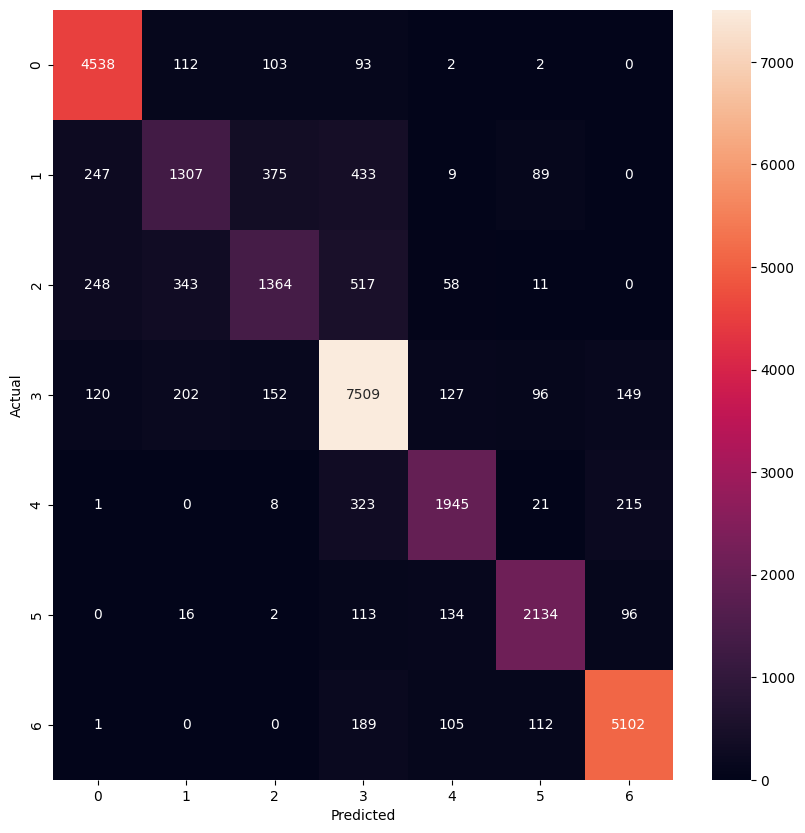

In [19]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')